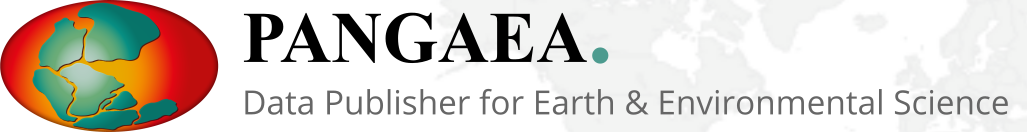

# **How to retrieve data from PANGAEA**

Version: 0.0.2<br>
By: Michael Oellermann, Kathrin Riemann-Campe<br>
Last updated: 2023-03-14

This notebook will guide you how to retrieve diverse earth- and environmental data and its metadata from the [PANGAEA data repository](https://www.pangaea.de) using Python. It uses the [PangaeaPy package](https://github.com/pangaea-data-publisher/pangaeapy), to facilitate the data download.

Run this notebook in:
* [GoogleColab](https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb): <a target="_blank" href="https://colab.requery.google.com/github/pangaea-data-publisher/community-workshop-material/blob/master/Python/Get_pangaea_data/get_pangaea_data.ipynb">
  <img src="https://colab.requery.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
* MyBinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pangaea-data-publisher/community-workshop-material/HEAD)

# 1. Import libraries

In [ ]:
import os
import pandas as pd
import openpyxl

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Pangaeapy
#!pip install pangaeapy # Uncomment to install pangaeapy
import pangaeapy as pan
from pangaeapy.pandataset import PanDataSet

# Web scraping
from bs4 import BeautifulSoup
from urllib.request import urlopen, urlretrieve
import json
from pandas import json_normalize

# To access genebank records
#!pip install biopython # To install biopython library
from Bio import Entrez
from Bio import SeqIO
Entrez.email = "your_email@example.com"

# 2. Query for data in PANGAEA

AIM: What data can I find for a particular topic such as a species, location or author?

This mirrors the query via the [PANGAEA website](https://pangaea.de/)

## 2.1 Simple query
Note:
* limit = the total number of datasets to be returned from query is 500.
    * To download > 500 use the offset attribute e.g. pan.PanQuery("Triticum", limit = 500, offset=500)
* type: child = data set as part of a data collection, parent = data collection
* score: Indicates how well the dataset matched the query term

In [ ]:
# query database for Helgoland Roads
query = pan.PanQuery("Triticum")
print(f'There have been {query.totalcount} query results')
# Save query as dataframe
query_results = pd.DataFrame(query.result)
query_results.head(4)

## 2.2 More complex queries

[More information](https://wiki.pangaea.de/wiki/PANGAEA_query) how to query with keywords


Multiple query terms

In [ ]:
# Finds datasets that contain both "marine" and "geology"
query = pan.PanQuery("marine geology")
print(f'There have been {query.totalcount} query results')

Optional query terms

In [ ]:
# Find datasets that contain "Globigerina" and either "falconensis" or "bulloides" 
query = pan.PanQuery("Globigerina AND (falconensis OR bulloides)")
print(f'There have been {query.totalcount} query results')

Uncertain spelling

In [ ]:
# Finds datasets with "Neogloboquadrina" regardless of your spelling mistake
query = pan.PanQuery("~Neogloboqadrina")
print(f'There have been {query.totalcount} query results') 

Specific author

In [ ]:
#  	Finds datasets of author "Herzschuh"
query = pan.PanQuery("author:Herzschuh")
print(f'There have been {query.totalcount} query results') 

Within geolocation

In [ ]:
# query database for "Deep-sea Sponge Microbiome Project" within a certain geolocation
query = pan.PanQuery("Deep-sea Sponge Microbiome Project", limit = 500, bbox=(17.7, 67.7, 21, 69))
print(f'There have been {query.totalcount} query results')

## 2.3 Queries exceeding 500 results

### Function to query Pangaea without limited results

In [ ]:
# Function to query pangaea for datasets
# This function overcomes the limit of 500 datasets
def query_pangaea(query_term = "", limit = 500, exclude_parents = True):
    query = pan.PanQuery(query_term, limit = limit)
    print(f'{query.totalcount} total query results. Query limited to {limit} results.')

    # Save query as dataframe
    query_results = pd.DataFrame(query.result)
    
    # Constrain query to limit
    if limit:
        query.totalcount = limit

    # if more than 500 query increase the offset to overcome data download limit
    if query.totalcount > 500:
        for offset in range(500, int(query.totalcount), 500):
            # new query with increased offset
            query = pan.PanQuery(query_term, offset=offset, limit = 500)
            # Attach further query results
            query_results = pd.concat([query_results, pd.DataFrame(query.result)])

    # Exclude parents if true
    if exclude_parents:        
        query_results = query_results[query_results.type == "child"]
        print(f'{len(query_results)} child datasets extracted')

    # Delete redundant columns
    query_results = query_results.drop(["html", "position"], axis = 1)
    # Rename URI to doi
    query_results.rename(columns={"URI": "doi"})
    
    return query_results.reset_index(drop=True)

Perform query

In [ ]:
# Perform PANGAEA query
query_term = "citation:author:Herzschuh"
query_results = query_pangaea(query_term, limit = 50, exclude_parents=True)
query_results.head(2)

### Add Pangaea ID

In [ ]:
# Function to extract and add pangaea ID to query result dataframe
def add_pangaea_id(query_df):
    # Extract PANGAEA dataset ID
    if "pangaea_id" not in query_df.columns:
        return query_df.insert(0, "pangaea_id", [int(id.split(".")[-1:][0]) for id in query_df.URI])

# Add pangaea dataset ids
add_pangaea_id(query_results)
query_results.head(2)

# 3. Download datasets

## 3.1 Download single dataset

AIM: How can I download a single dataset right into Python or onto my harddrive?

### Seach for datasets

In [ ]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 50, exclude_parents=True)
# Add pangaea dataset ids
add_pangaea_id(query_results)
query_results.head(2)

### Download dataset
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.923033

In [ ]:
# Download dataset from PANGAEA
ds = PanDataSet(923033)
ds.data.head(3)

### Translate to long parameter names
Because by default parameters are abbreviated without units

In [ ]:
# Translate short parameters names to long names including unit
def get_long_parameters(ds):
    """Translate short parameters names to long names including unit

    Args:
        ds (PANGAEA dataset): PANGAEA dataset
    """
    ds.data.columns =  [f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()]

print(ds.data.columns[:10])
get_long_parameters(ds)
ds.data.columns[:10]

### Display location of dataset samples

In [ ]:
# Plot sampling points on interactive plotly map
fig = px.scatter_mapbox(ds.data, lat="LATITUDE", lon="LONGITUDE", 
                        hover_name="Event label", 
                        hover_data=['LATITUDE', 'LONGITUDE', 'DEPTH, water [m]', 'Species', 'Gear'], 
                        zoom=0, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Save data

In [ ]:
# Create data folder
data_folder = "pangaea_data"
# Check if it already exists before creating it
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)
# Save to csv
print(f'PANGAEA dataset {ds.id} saved')
ds.data.to_csv(os.path.join(data_folder, f'Pangaea_dataset_{ds.id}.csv'))

# 3.2 Download multiple datasets

AIM: How can I download multiple datasets right into Python or on my harddrive?

### Perform query

In [ ]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 50, exclude_parents=True)
query_results.head(2)

### Download multiple datasets
Note: 
* Parent and restricted datasets cannot be downloaded

In [ ]:
# Add pangaea dataset ids
add_pangaea_id(query_results)

# Create dictionary to store dataframes in
data_dict = {}
# Loop over IDs and download datasets
for pangaea_id in query_results.pangaea_id[:4]:
    print("".join(40*["-"]))
    print(f'Pangaea ID: {pangaea_id}')
    # Cache
    ds = PanDataSet(pangaea_id, enable_cache=True)
    # Translate to long parameter names
    get_long_parameters(ds)
    print(f'Dataset title: {ds.title}')
    print(ds.data.head(2))
    data_dict[pangaea_id] = ds.data

### Save multiple datasets

In [ ]:
# Create data folder
data_folder = "pangaea_data"
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)
# Loop over each dataset in the dictionary and save to csv
for key, df in data_dict.items():
    print(f'PANGAEA dataset {key} saved')
    # Save to csv
    data_dict[key].to_csv(os.path.join(data_folder, f'Pangaea_dataset_{key}.csv'))

# 4. Get metadata

## 4.2 Get metadata for each dataset

#### Download dataset

In [ ]:
# Download dataset from PANGAEA
ds = PanDataSet(923033, include_data=False)
ds.data

### Basic metadata retrieval

In [ ]:
# Title
print(f'Title: {ds.title}')
# Abstract
print(f'Abstract: {ds.abstract}')
# Publication date
print(f'Publication date: {ds.date}')
# Authors
print(f'Authors: {"; ".join([x.fullname for x in ds.authors])}')
# Author orcids
print(f'Orcids: {"; ".join([x.ORCID if x.ORCID else "no ORCID" for x in ds.authors])}')
# Citation
print(f'Citation: {ds.citation}')
# doi
print(f'doi: {ds.doi}')
# Geolocation
print(f'Latitude: {ds.geometryextent["meanLatitude"]}')
print(f'Longitude: {ds.geometryextent["meanLongitude"]}')
# Parameters
params = "; ".join([f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()])
print(f'Parameters: {params}')
# Event devices
print(f'Event devices: {"; ".join(set([device for device in ds.getEventsAsFrame()["device"]]))}')

### Getting metadata for multiple datasets

#### Function to extract PANGAEA metadata

In [ ]:
# Function to extract metadata from Pangaea dataset
def get_pangaea_meta(pangaea_id):
    try:
        print(f'Extract metadata for Pangaea ID: {pangaea_id}')
        # Get metadata for pangaea dataset
        ds = pan.PanDataSet(pangaea_id, enable_cache=True, include_data=False)
        # Create data frame to store metadata
        meta = pd.DataFrame({"pangaea_id": [pangaea_id]})
        # Extract and add metadata    
        meta["year"] = ds.year
        meta["authors"] = "; ".join([x.fullname for x in ds.authors])
        meta["title"] = ds.title
        meta["abstract"] = ds.abstract 
        meta["citation"] = ds.citation
        meta["parameters"]= "; ".join([f'{param.name} [{param.unit}]' if param.unit else param.name for param in ds.params.values()])
        meta["publication_date"] = ds.date
        # Check if there are geometry metadata
        if ds.geometryextent:
            meta["mean_latitude"] = ds.geometryextent["meanLatitude"]
            meta["mean_longitude"] = ds.geometryextent["meanLongitude"]
        # Check if events are available
        if not ds.getEventsAsFrame().empty:   
            meta["events"] = "; ".join(ds.getEventsAsFrame()["label"])
            meta["event_device"] = ds.getEventsAsFrame()["device"]
            meta["elevation"] = ds.getEventsAsFrame()["elevation"]
            meta["campaign"] = ds.getEventsAsFrame()["campaign"]
            meta["location"] = ds.getEventsAsFrame()["location"]
        meta["doi"] = ds.doi
        meta["datastatus"] = ds.datastatus
    except AttributeError:
        meta = pd.DataFrame()
    
    return meta

#### Function to download metadata from multiple datasets

In [ ]:
# Function to download multiple Pangaea metadata
def get_pangaea_meta_df(query_term, pangaea_id_list, folder = "PANGAEA_metadata"):
    # Create folder for metadata
    if os.path.isdir(folder):
        print(f'{folder} already exists')
    # if not create it    
    else:
        os.mkdir(folder)
    
    # Create file path
    file_path = f'{os.path.join(os.getcwd(), folder)}\\metadata_{query_term.replace(":", "_")}.csv'
    # Add check if data have already been downloaded
    if os.path.isfile(file_path):
        print("File already exists")
        meta_df = pd.read_csv(file_path)
    else:
        meta_df = {}
        # Retrieve and store metadata in dictionary
        for id in pangaea_id_list:
            meta_df[id] = get_pangaea_meta(id)
        # Join all metadata into single dataframe
        meta_df = pd.concat(meta_df)
        # Save metadata to csv file
        meta_df.to_csv(file_path)
        print(f'Pangaea metadata saved as {file_path}')
    return meta_df

#### Use these functions to download metadata

In [ ]:
# Perform PANGAEA query
query_term = "citation:author:Herzschuh"
query_results = query_pangaea(query_term, limit = 60)
# Add pangaea dataset ids
add_pangaea_id(query_results)
# Extract metadata for all query results
meta_df = get_pangaea_meta_df(query_term = query_term, pangaea_id_list = query_results["pangaea_id"])

### 4.2.2 The WebScraper way
* --> To access metadata via direct web scraping
* ... and to apply this more generic approach to scrape data from other repositories

#### First define scraping functions

In [ ]:
# Function to extract the full PANGAEA dataset web content
def get_html(url):
    """Function to extract html web content

    Args:
        dataset_id (str): PANGAEA dataset ID

    Returns:
        str: html content of PANGAEA dataset
    """
    page = urlopen(url)
    html = page.read().decode("utf-8")
    return BeautifulSoup(html, "html.parser")

# Function to extract PANGAEA metadata
def get_pan_metadata(dataset_html, metadata):
    """Function to scrape metadata from PANGAEA dataset html content

    Args:
        dataset_html (str): html content of PANGAEA dataset
        metadata (str): metadata type to be extracted

    Returns:
        str: Extracted metadata
    """
    return dataset_html.find("meta", attrs={"name": metadata}).get("content")

#### See what metadata are available
Note:
* Example dataset: https://doi.org/10.1594/PANGAEA.923035
* You can view the source code in the browser by pressing CTRL + U (in Firefox)

In [354]:
# Scrape PANGAEA dataset
html = get_html("https://doi.org/10.1594/PANGAEA.923035")
# Extract all available metadata types
for meta in html.find_all("meta"):
    if meta.has_attr("name"):
        print(meta.attrs["name"])

viewport
title
author
date
keywords
description
geo.position
ICBM
DC.title
DC.creator
DC.creator
DC.publisher
DC.date
DC.type
DC.language
DCTERMS.license
DC.identifier
DC.rights
DC.format
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation
DC.relation


In [368]:
# Get the abstract
html.find("meta", attrs={"name": "title"}).get("content")

'CTD profiles of the global Deep-sea Sponge Microbiome Project'

#### Scrape the html content for multiple PANGAEA dataset

Perform query

In [ ]:
# Perform PANGAEA query
query_term = "Deep-sea Sponge Microbiome Project"
query_results = query_pangaea(query_term, limit = 5, exclude_parents=True)
query_results

In [ ]:
# Generate url from uri
query_results["url"] = [f'https://doi.org/{uri.split(":")[-1:][0]}' for uri in query_results.URI]
# Scrape the html content for each PANGAEA dataset
query_results["html"] = [get_html(url) for url in query_results["url"]]

#### Exctract desired metadata from each dataset

In [363]:
# Extract desired metadata from dataset html
for counter, metadata in enumerate(["title", "author", "date", "geo.position", "description"]):
    # Check if metadata already exist
    if metadata not in query_results.columns:
        query_results.insert(counter+1, metadata, [get_pan_metadata(html, metadata) for html in query_results["html"]])

# Extract the abstract
query_results["abstract"] = [html.find("div", attrs={"class": "abstract"}).get_text() for html in query_results["html"]]
query_results.head(2)

,URI,title,author,date,geo.position,description,score,type,url,html,abstract
0,doi:10.1594/PANGAEA.923035,CTD profiles of the global Deep-sea Sponge Mic...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,36.984859;154.589072,"Busch, Kathrin; Hentschel, Ute (2022): CTD pro...",216.81989,child,https://doi.org/10.1594/PANGAEA.923035,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...
1,doi:10.1594/PANGAEA.923033,Metadata and NCBI-Accession numbers of the glo...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,42.626109;158.916347,"Busch, Kathrin; Hentschel, Ute (2022): Metadat...",213.10428,child,https://doi.org/10.1594/PANGAEA.923033,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...


## 4.3 Save metadata

In [371]:
# Save metadata
query_results.to_excel(os.path.join("PANGAEA_metadata", f'Pangaea_metadata_html.xlsx'), index=False)
query_results

,URI,title,author,date,geo.position,description,score,type,url,html,abstract
0,doi:10.1594/PANGAEA.923035,CTD profiles of the global Deep-sea Sponge Mic...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,36.984859;154.589072,"Busch, Kathrin; Hentschel, Ute (2022): CTD pro...",216.819890,child,https://doi.org/10.1594/PANGAEA.923035,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...
1,doi:10.1594/PANGAEA.923033,Metadata and NCBI-Accession numbers of the glo...,"Busch, Kathrin; Hentschel, Ute",2022-07-27,42.626109;158.916347,"Busch, Kathrin; Hentschel, Ute (2022): Metadat...",213.104280,child,https://doi.org/10.1594/PANGAEA.923033,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",The Deep-sea Sponge Microbiome Project is a la...
2,doi:10.1594/PANGAEA.923271,"Metadata, flow cytometry data, and NCBI-Access...","Busch, Kathrin; Taboada, Sergi; Riesgo, Ana; K...",2020-09-30,43.993310;-5.513115,"Busch, Kathrin; Taboada, Sergi; Riesgo, Ana; K...",53.984203,child,https://doi.org/10.1594/PANGAEA.923271,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",Connectivity is a fundamental process driving ...
3,doi:10.1594/PANGAEA.909246,"Collection data, 16S microbiome and metabolome...","Steffen, Karin; Indraningrat, Anak Agung Gede;...",2019-11-29,63.085783;-60.213565,"Steffen, Karin; Indraningrat, Anak Agung Gede;...",52.710970,child,https://doi.org/10.1594/PANGAEA.909246,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",Collection data of the marine sponge specimens...
4,doi:10.1594/PANGAEA.913907,Metadata and NCBI-Accession numbers of 16S dat...,"Busch, Kathrin; Beazley, Lindsay; Kenchington,...",2020-03-24,44.046375;-62.944014,"Busch, Kathrin; Beazley, Lindsay; Kenchington,...",45.562748,child,https://doi.org/10.1594/PANGAEA.913907,"[html, \n, [\n, [\n, <meta charset=""utf-8""/>, ...",Anthropogenic pressures on marine ecosystems a...


## 4.4 More metadata: Can be extracted from json

In [372]:
# Extract json string from html
query_results["json"] = [html.find("script", attrs={"type": "application/ld+json"}).string for html in query_results["html"]]
#See what metadata are available
print(json.loads(query_results["json"][0]))
# Ad json metadata to dataframe
print([json.loads(json_str)["name"] for json_str in query_results["json"]])
# Extract nested metadata such as ORCID ID
print(json_normalize(json.loads(query_results["json"][0])["creator"])["@id"])

{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.923035', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.923035', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.923035', 'creator': [{'@id': 'https://orcid.org/0000-0001-7621-998X', '@type': 'Person', 'name': 'Kathrin Busch', 'familyName': 'Busch', 'givenName': 'Kathrin', 'identifier': 'https://orcid.org/0000-0001-7621-998X', 'email': 'kbusch@geomar.de'}, {'@id': 'https://orcid.org/0000-0003-0596-790X', '@type': 'Person', 'name': 'Ute Hentschel', 'familyName': 'Hentschel', 'givenName': 'Ute', 'identifier': 'https://orcid.org/0000-0003-0596-790X', 'email': 'uhentschel@geomar.de'}], 'name': 'CTD profiles of the global Deep-sea Sponge Microbiome Project', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', '

# 5. Download specific parameters across multiple datasets

## 5.1 Check the frequency of parameters

Combine data headers from all data frames 

In [373]:
params = pd.DataFrame()
# Extract and combine headers of all data sets
for key, df in data_dict.items():
    params = pd.concat([params, df.columns.to_frame()], ignore_index=True, axis=0)
# Rename the column
params = params.rename(columns={0: "parameters"})
params.head(10)

,parameters
0,Event label
1,Profile
2,Station label
3,LATITUDE
4,LONGITUDE
5,"Pressure, water [dbar]"
6,"Temperature, water [°C]"
7,Salinity
8,Elevation [m]
9,Date/Time


Plot parameter frequency

parameters
Accession number, genetics    7
Event label                   4
Elevation [m]                 4
Code                          4
LONGITUDE                     3
LATITUDE                      3
DEPTH, water [m]              3
Identification                3
Measurement conducted         3
Salinity                      3
Name: count, dtype: int64


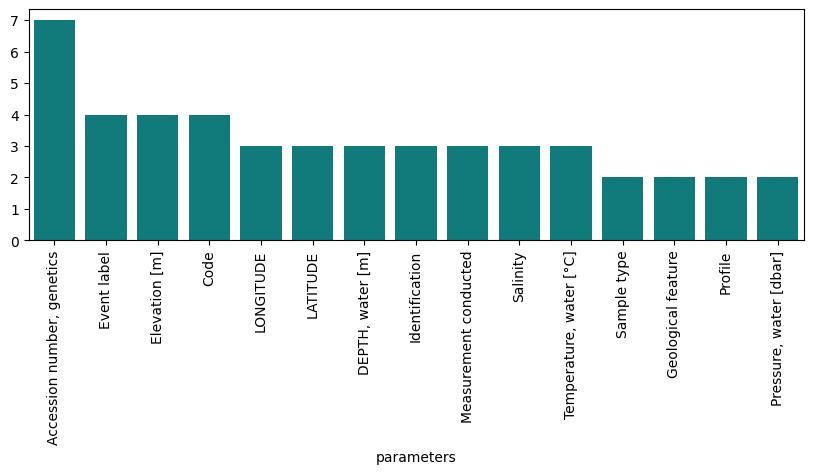

In [374]:
# Calculate the parameter frequency
param_count = params["parameters"].value_counts()
print(param_count.head(10))
# Plot the parameter frequency
plt.figure(figsize=(10,3))
count_plot = sns.barplot(x = param_count.index[:15], y = param_count.values[:15], color="darkcyan")
count_plot = count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=90)

## 5.2 Extract and combine parameters from data frames

#### Function to extract specific parameter(s) from dataframes
**!!! Key benefit of harmonised parameters in a well curated data repository**

In [375]:
# Function to find and extract desired parameters across all dataframes
def get_param_data(data_dict, params):
    """Function to find and extract desired parameters across all dataframes

    Args:
        params (list): List of parameters to be extracted

    Returns:
        pandas.core.frame.DataFrame: Data frame containing data for all parameters
    """

    # Define empty dictionary to temporarily store extracted data
    extracted_data = {}
    # Loop over all dataframe, look for and extract parameters
    for key, df in data_dict.items():
        # Find parameters that exists in the dataset
        found_params = list(set(params).intersection(set(df.columns)))
        if found_params:
            print(f'Found the parameters {found_params} in dataset {key}')
            # Copy found parameters to new dataframe
            df_sub = df[found_params]
            # Insert PANGAEA dataset ID
            df_sub.insert(0, "Pangaea_dataset_id", key)
            # Store extracted data in dictionary
            extracted_data[key] = df_sub

    # Join all dataframe in dictionary
    extracted_data = pd.concat(extracted_data, ignore_index = True)
    return extracted_data

#### Extract and save specific parameters from dataframes

In [376]:
# Enter all parameters to be extracted
extracted_data = get_param_data(data_dict, ["LATITUDE", "LONGITUDE", "Date/Time", "DEPTH, water [m]", "Salinity"])
# Save extracted data parameters
extracted_data.to_csv(os.path.join(data_folder, f'Extracted_data.csv'), index=False)
extracted_data

Found the parameters ['LATITUDE', 'LONGITUDE', 'Salinity', 'Date/Time'] in dataset 923035
Found the parameters ['LATITUDE', 'LONGITUDE', 'Salinity', 'DEPTH, water [m]'] in dataset 923033
Found the parameters ['DEPTH, water [m]'] in dataset 923271
Found the parameters ['LATITUDE', 'LONGITUDE', 'Salinity', 'DEPTH, water [m]'] in dataset 909246


,Pangaea_dataset_id,LATITUDE,LONGITUDE,Salinity,Date/Time,"DEPTH, water [m]"
0,923035,44.318200,-62.606200,31.49,2016-01-01,NaN
1,923035,44.318200,-62.606200,31.51,2016-01-01,NaN
2,923035,44.318200,-62.606200,31.54,2016-01-01,NaN
3,923035,44.318200,-62.606200,31.59,2016-01-01,NaN
4,923035,44.318200,-62.606200,31.61,2016-01-01,NaN
...,...,...,...,...,...,...
64385,909246,64.891000,-58.551267,34.70,NaT,561.0
64386,909246,61.147942,-63.560678,34.82,NaT,563.0
64387,909246,63.098560,-60.221100,34.90,NaT,916.0
64388,909246,62.655480,-59.158160,34.91,NaT,1036.0


# 6. Download linked genetic data

## 6.1 Download PANGAEA dataset with genetic accession numbers
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.937551

In [377]:
# Download dataset from PANGAEA
ds = PanDataSet(937551)
get_long_parameters(ds)
df = ds.data.head(4)
df.head(2)

,Event label,Area/locality,Sample ID,Treatment: pH,Treatment: temperature [°C],Treatment,Treatment: time after [h],Hydrogen evolution activity [nmol/min/mg],"Hydrogen evolution activity, standard deviation [±]",Hydrogen evolution activity [%],"Hydrogen evolution activity, standard deviation [±]","Accession number, genetics",Sample method,Comment,Latitude [deg],Longitude [deg],Elevation [m],Date/Time
0,M78/2_324,Lilliput hydrothermal field,Lilli33G1,NaN,NaN,NaN,NaN,153.22,8.65,NaN,NaN,insdc:MG456606,Diffuse hydrothermal fluids were collected fro...,NaN,-9.543833,-13.212833,-1519.0,2009-01-01
1,M78/2_314,Nibelungen hydrothermal field,Nib22E5,NaN,NaN,NaN,NaN,13.12,1.37,NaN,NaN,insdc:MG456605,Hydrothermal fluids were collected from Dragon...,NaN,-8.297167,-13.508833,-2886.0,2009-01-01


## 6.2. Download Genebank records

In [378]:
# Extract NCBI accession number from dataset
df.loc[:,"Accession number, genetics"] = [x.split(":")[1] for x in df.loc[:,"Accession number, genetics"]]
# Fetch gene records from NCBI
records = []
for acc_id in df["Accession number, genetics"]:
    print(acc_id)
    handle = Entrez.efetch(db="nucleotide", rettype="fasta", retmode="text",
                          id=acc_id)
    records.append(SeqIO.read(handle, 'fasta'))

MG456606
MG456605
MG456603
MG456604


## 6.3 Add genetic records to PANGAEA data frame

In [379]:
# Add gene description
df.loc[:, "Gene"] = [record.description for record in records]
# Add genetic sequence
df.loc[:, "Sequence"] = [record.seq for record in records]
df.head(2)

C:\Users\marum2022\AppData\Local\Temp\ipykernel_28848\3909503772.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marum2022\AppData\Local\Temp\ipykernel_28848\3909503772.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Event label,Area/locality,Sample ID,Treatment: pH,Treatment: temperature [°C],Treatment,Treatment: time after [h],Hydrogen evolution activity [nmol/min/mg],"Hydrogen evolution activity, standard deviation [±]",Hydrogen evolution activity [%],"Hydrogen evolution activity, standard deviation [±]","Accession number, genetics",Sample method,Comment,Latitude [deg],Longitude [deg],Elevation [m],Date/Time,Gene,Sequence
0,M78/2_324,Lilliput hydrothermal field,Lilli33G1,NaN,NaN,NaN,NaN,153.22,8.65,NaN,NaN,MG456606,Diffuse hydrothermal fluids were collected fro...,NaN,-9.543833,-13.212833,-1519.0,2009-01-01,MG456606.1 Uncultured bacterium clone fosmid p...,"(T, C, T, A, G, A, G, G, A, T, C, C, C, A, C, ..."
1,M78/2_314,Nibelungen hydrothermal field,Nib22E5,NaN,NaN,NaN,NaN,13.12,1.37,NaN,NaN,MG456605,Hydrothermal fluids were collected from Dragon...,NaN,-8.297167,-13.508833,-2886.0,2009-01-01,MG456605.1 Uncultured bacterium clone fosmid p...,"(G, T, G, G, T, A, C, A, A, T, G, C, A, C, G, ..."


# 7. Download binary files

## 7.1 Download PANGAEA dataset with image data
Dataset: https://doi.pangaea.de/10.1594/PANGAEA.943250

In [380]:
# Download dataset from PANGAEA
pan_id = 943250
ds = PanDataSet(pan_id)
get_long_parameters(ds)
df = ds.data.iloc[22:25,:]
df.head(2)

,Image,DATE/TIME,LONGITUDE,LATITUDE,"DEPTH, water [m]",Event,Elevation [m]
22,HOTKEY_2019_10_01_at_23_15_06_CP4A6694.JPG,2019-01-01,-5.947374,82.894183,4023.7,HACON19-24-OFOBS-03,-3930.0
23,HOTKEY_2019_10_01_at_23_19_28_CP4A6708.JPG,2019-01-01,-5.946048,82.894154,4021.7,HACON19-24-OFOBS-03,-3930.0


## 7.2 Download images

In [381]:
# Create file urls
df["image_url"] = [f'https://download.pangaea.de/dataset/{pan_id}/files/{img}' for img in df['Image']]
# Download images
for i, file_url in enumerate(df["image_url"]):
    urlretrieve(file_url, os.path.join(data_folder, df["Image"].iloc[i]))
    print(f'{file_url} downloaded')

C:\Users\marum2022\AppData\Local\Temp\ipykernel_28848\455756297.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



https://download.pangaea.de/dataset/943250/files/HOTKEY_2019_10_01_at_23_15_06_CP4A6694.JPG downloaded
https://download.pangaea.de/dataset/943250/files/HOTKEY_2019_10_01_at_23_19_28_CP4A6708.JPG downloaded
https://download.pangaea.de/dataset/943250/files/HOTKEY_2019_10_01_at_23_20_11_CP4A6711.JPG downloaded
